In [11]:
!pip3 install ipypb

In [12]:
from ipypb import track
import torch
import transformers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from dataclasses import dataclass
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import random

In [13]:
torch.set_grad_enabled(False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
@dataclass

class ModelConfig:
    '''
        threshold - граница минимальной магнитуды в разложении фурье, после которой считаем период выбросом и чем-то важным для модели
    '''
    model_name: str
    tokenizer_name: str
    threshold: float = 1.5

In [15]:
def get_numbers_embedding(model, tokenizer, p=521):
    # соберём эмбеддинги для чисел из одного токена, чтобы посмотреть на доминирующие периоды в разложении фурье
    embedding_matrix = [i for i in model.named_parameters()][0][1].data.detach() # у моделей в тетрадке одинаковое нахождение матрицы эмбеддингов, но для других надо будет менять строчечку
    single_token_nums_from_paper = [str(i) for i in range(p)]
    numbers_embeddings = embedding_matrix[tokenizer(single_token_nums_from_paper).input_ids].squeeze() # (p, 4096)

    return numbers_embeddings

In [16]:
P = 521 # 520 - максимальное число, все числа до которого представляются единым токеном 

In [17]:
def build_fourier_basis(p):
    
    # Initialize Fourier basis and their names
    fourier_basis = [torch.ones(p) / np.sqrt(p)]  # Add constant term to the basis
    fourier_basis_names = ['Const']  # Name for the constant term

    # Generate Fourier basis
    for i in range(1, p // 2 + 1):
        cos_basis = torch.cos(2 * torch.pi * torch.arange(p) * i / (p-1)) # вектор размера 521 - [0, 520]
        sin_basis = torch.sin(2 * torch.pi * torch.arange(p) * i / (p-1))
        
        # Normalize the vectors
        cos_basis /= cos_basis.norm()
        sin_basis /= sin_basis.norm()
        
        # Append to lists
        fourier_basis.extend([cos_basis, sin_basis])
        fourier_basis_names.extend([f'cos {i}', f'sin {i}'])

    # Convert to a tensor and move to GPU
    fourier_basis = torch.stack(fourier_basis, dim=0).to(device)
    return fourier_basis, fourier_basis_names

In [18]:
fourier_basis, fourier_basis_names = build_fourier_basis(P)

In [19]:
def convert_base_to_base10(a, b):
    return int(str(a), b)
def convert_base10_to_base(x, b):
    return np.base_repr(x, base=b)
def melt(tensor):
    arr = tensor.numpy()
    n = arr.ndim
    grid = np.ogrid[tuple(map(slice, arr.shape))]
    grid[1][0] = [np.base_repr(number, base=10) for number in grid[1][0]]
    out = np.empty(arr.shape + (n+1,), dtype=np.result_type(arr.dtype, int))
    offset = 1

    for i in range(n):
        out[..., i+offset] = grid[i]
    out[..., -1+offset] = arr
    out.shape = (-1, n+1)

    df = pd.DataFrame(out, columns=['value']+[str(i)
                    for i in range(n)], dtype=float)
    return df.convert_dtypes([float]+[int]*n)

def embed_to_cos_sin(fourier_embed):
    if len(fourier_embed.shape) == 1:
        return torch.stack([fourier_embed[1::2], fourier_embed[2::2]])
    else:
        return torch.stack([fourier_embed[:, 1::2], fourier_embed[:, 2::2]], dim=1)
def identify_outliers(df, threshold):
    # Ensure data is a floating point tensor for mean and std calculations
    data = torch.tensor(df['value'].values, dtype=torch.float)  # Convert to tensor

    df['IsOutlier'] = False  # Initialize the column with False
    # Calculate the mean using torch
    mean = torch.mean(data)
    # Find indices of outliers
    for index, row in df.iterrows():
        score = row['value']
        if abs(score) > threshold:
            df.at[index, 'IsOutlier'] = True 
    return df

In [20]:
def plot_embed_bars(fourier_embed, threshold=1.5,  title='Norm of embedding of each Fourier Component', return_fig=False, **kwargs):
    cos_sin_embed = embed_to_cos_sin(fourier_embed)
    df = melt(cos_sin_embed)
    # display(df)
    group_labels = {0: 'sin', 1: 'cos'}
    df['Trig'] = df['0'].map(lambda x: group_labels[x])     
    # Identify outliers within the function
    print(len(fourier_embed))
    df = identify_outliers(df, threshold)

    df['1'] = df['1'].apply(lambda x: convert_base10_to_base(convert_base_to_base10(x,10) + 1, 10)) #start from 1 . end to p//2. . so that x axis represent the i in torch.cos(2*torch.pi*torch.arange(p)*i/p)  
    # Now, filter the DataFrame to show only the outliers
    df['1_base10'] = df['1'].apply(lambda x: convert_base_to_base10(x, 10))
    df['period'] = np.round((P-1) / df['1_base10'], 2)
    outliers_df = df[df['IsOutlier']]
    # print(df)
    print(outliers_df)
    fig = px.bar(df, barmode='group', color='Trig', x='1_base10', y='value', labels={
                '1': '$w_k$', 'value': 'Norm'}, title=title, **kwargs)
    fig.update_xaxes(tickvals=np.arange(0, len(df['1_base10'].unique()), 5), ticktext=df['1'].unique()[::5])
    
    fig.update_layout(dict(legend_title=""), width=1200, height=800)
    # Add vertical lines and annotations for each outlier
    initial_ay = -30  # Start with annotations below the line
    for index, row in outliers_df.iterrows():
        # не берём слишком больште периоды на график, пусть в табличке посмотрят
        if row['1_base10'] < 50:
            continue
        x_index = row['1_base10']  # The x-axis value from your dataframe
        x_value = row['1']
        y_val = row['value']  # The y-axis (norm) value from your dataframe
        # Add a vertical line for the outlier
        # fig.add_vline(x=x_index, line_width=0.5, line_dash="dash", line_color="red")
        # Add an annotation for the outlier
        fig.add_annotation(x=x_index, y=0,
                        text=f"x:{x_value}, T={(P-1)/int(x_value):.2f}",  # Displaying x and y values
                        showarrow=True, arrowhead=1, arrowsize=1,
                        arrowwidth=2, arrowcolor="red",
                       ax=20,  # Horizontal offset
                       ay=initial_ay,  # Vertical offset, may need adjustment
                        bgcolor="white", font=dict(color="red", size=12))
    # Alternate the vertical offset for the next annotation
        initial_ay *= -1  # This will toggle between positive and negative values

    return fig


### посмотрим на интересные периоды в эмбеддингах для чисел

модели: GPT-J, GPT-2-XL, GPT-2-XL - finetuned на задачу сложения

#### GPT-J embedding matrix

In [12]:
gptj_config = ModelConfig(
    model_name = "EleutherAI/gpt-j-6B",
    tokenizer_name = "EleutherAI/gpt-j-6B",
    threshold = 1.25
)

In [13]:
model = transformers.GPTJForCausalLM.from_pretrained(gptj_config.model_name, revision="float16",torch_dtype=torch.float16).to(device)
tokenizer = transformers.AutoTokenizer.from_pretrained(gptj_config.tokenizer_name)
embedding_matrix_gptj = get_numbers_embedding(model, tokenizer)
embedding_matrix_gptj.shape

config.json:   0%|          | 0.00/836 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/12.1G [00:00<?, ?B/s]

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

tokenizer_config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

In [59]:
fig_gptj = plot_embed_bars(torch.norm(embedding_matrix_gptj.T.cpu() @ fourier_basis.T.half().cpu(), dim=0), gptj_config.threshold,
                f'Number Embedding in Fourier Space: GPT-J', return_fig=True)
fig_gptj.show()

521
        value  0    1 Trig  IsOutlier  1_base10  period
0      2.6875  0    1  sin       True         1  520.00
1    2.068359  0    2  sin       True         2  260.00
2    1.737305  0    3  sin       True         3  173.33
3    1.551758  0    4  sin       True         4  130.00
4    2.275391  0    5  sin       True         5  104.00
5    1.352539  0    6  sin       True         6   86.67
9    1.631836  0   10  sin       True        10   52.00
10   1.291992  0   11  sin       True        11   47.27
15   1.363281  0   16  sin       True        16   32.50
20   1.444336  0   21  sin       True        21   24.76
25   1.458984  0   26  sin       True        26   20.00
30   1.316406  0   31  sin       True        31   16.77
51   2.015625  0   52  sin       True        52   10.00
103  2.013672  0  104  sin       True       104    5.00
129  1.526367  0  130  sin       True       130    4.00
155  1.525391  0  156  sin       True       156    3.33
172  1.763672  0  173  sin       True       

Как видим, в эмбеддингах для чисел действительно прослеживаются скачки в магнитуде для некоторых интересных периодов: 2, 2.5, 3.01 (наверное 3, но floating point и 520 не делится нацело на 3, так что как есть), 3.33, 4, 5, 10.

В итоге автор решил фитить хеликс только на периодах 2, 5, 10, 100

#### GPT-2-XL embedding matrix

In [13]:
gpt2xl_config = ModelConfig(
    model_name = "gpt2-xl",
    tokenizer_name = "gpt2-xl",
    threshold = 2.0
)

In [14]:
tokenizer_gpt2xl = transformers.GPT2Tokenizer.from_pretrained(gpt2xl_config.tokenizer_name)
model_gpt2xl = transformers.AutoModelForCausalLM.from_pretrained(gpt2xl_config.model_name).to(device)
embedding_matrix_gpt2xl = get_numbers_embedding(model_gpt2xl, tokenizer_gpt2xl)
embedding_matrix_gpt2xl.shape

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

2025-06-25 12:44:10.425609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750855450.630776      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750855450.691475      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

torch.Size([521, 1600])

In [16]:
fig_embs_fourier = plot_embed_bars(torch.norm(embedding_matrix_gpt2xl.T.cpu() @ fourier_basis.T.cpu(), dim=0), gpt2xl_config.threshold,
                f'Number Embedding in Fourier Space: GPT2-XL ', return_fig=True)
fig_embs_fourier.show()

521
        value  0    1 Trig  IsOutlier  1_base10  period
0    6.311502  0    1  sin       True         1  520.00
1    4.218034  0    2  sin       True         2  260.00
2     3.49039  0    3  sin       True         3  173.33
3    3.193642  0    4  sin       True         4  130.00
4    4.147656  0    5  sin       True         5  104.00
5    2.776269  0    6  sin       True         6   86.67
6    2.413041  0    7  sin       True         7   74.29
7    2.204122  0    8  sin       True         8   65.00
8     2.07094  0    9  sin       True         9   57.78
9    3.049593  0   10  sin       True        10   52.00
10   2.512243  0   11  sin       True        11   47.27
11   2.022097  0   12  sin       True        12   43.33
14   2.056424  0   15  sin       True        15   34.67
15    2.46876  0   16  sin       True        16   32.50
20   2.325998  0   21  sin       True        21   24.76
25   2.012733  0   26  sin       True        26   20.00
51   3.227956  0   52  sin       True       

для GPT-2-XL вырисовываются те же периоды, что и для GPT-J, но уже без 3

#### GPT-2-XL finetuned на задачу сложения embedding matrix periods

In [21]:
gpt2xl_finetuned_config = ModelConfig(
    model_name = "Onlydrinkwater/gpt2xl_language_math_520_10base",
    tokenizer_name = "gpt2-xl",
    threshold = 2.0
)

In [22]:
tokenizer_gpt2xl_finetuned = transformers.GPT2Tokenizer.from_pretrained(gpt2xl_finetuned_config.tokenizer_name)
model_gpt2xl_finetuned = transformers.AutoModelForCausalLM.from_pretrained(gpt2xl_finetuned_config.model_name).to(device)
embedding_matrix_gpt2xl_finetuned = get_numbers_embedding(model_gpt2xl_finetuned, tokenizer_gpt2xl_finetuned)
embedding_matrix_gpt2xl_finetuned.shape

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

2025-06-25 17:21:03.901916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750872064.106646      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750872064.164305      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

torch.Size([521, 1600])

In [23]:
gpt2xl_finetuned_fig = plot_embed_bars(torch.norm(embedding_matrix_gpt2xl_finetuned.T.cpu() @ fourier_basis.T.cpu(), dim=0), gpt2xl_finetuned_config.threshold,
                f'Number Embedding in Fourier Space: GPT2-XL-finetuned ', return_fig=True)
gpt2xl_finetuned_fig.show()

521
        value  0    1 Trig  IsOutlier  1_base10  period
0    6.194099  0    1  sin       True         1  520.00
1    4.208409  0    2  sin       True         2  260.00
2    3.519808  0    3  sin       True         3  173.33
3    3.178364  0    4  sin       True         4  130.00
4    4.123577  0    5  sin       True         5  104.00
5    2.833616  0    6  sin       True         6   86.67
6    2.430425  0    7  sin       True         7   74.29
7    2.231955  0    8  sin       True         8   65.00
8    2.093816  0    9  sin       True         9   57.78
9    3.191998  0   10  sin       True        10   52.00
10   2.790895  0   11  sin       True        11   47.27
11   2.071151  0   12  sin       True        12   43.33
14    2.06983  0   15  sin       True        15   34.67
15   2.596196  0   16  sin       True        16   32.50
20   2.537265  0   21  sin       True        21   24.76
51   3.491135  0   52  sin       True        52   10.00
103  3.838818  0  104  sin       True       

для GPT-2-XL finetuned на задачу сложения - те же периоды, что и для GPT-2-XL

### фитим хеликсы для моделей и смотрим, можем ли мы этими хеликсами корраптить поведение модели

в программе:
1. собираем активации с 0, 16, последнего слоя для токена а из ПРОМПТА на сложение. (соберём для каждого числа из [0,260])
2. PCA эти хиддены в размерность 100 - чтобы не было оверфита
3. обучим матрицу C для каждого слоя, матрица С - 100x9, уравнение: PCA(hidden) = C_pca @ helix_base
4. 

In [24]:
T_PERIODS = [2, 5, 10, 100]

In [25]:
#model.eval()
#model_gpt2xl.eval()
model_gpt2xl_finetuned.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=4800, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=1600)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=6400, nx=1600)
          (c_proj): Conv1D(nf=1600, nx=6400)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

In [26]:
def generate_prompts():
    '''
        генерация промптов с примерами сложения для сбора активация и проведения коррупционных схем
    '''
    prompts = []
    a_b_pairs = [(a, b) for a in range(100) for b in range(100)]
    for pair in a_b_pairs:
        a, b = pair[0], pair[1]
        answer = a + b
        prompt = f"Output ONLY a number. {a}+{b}="
        prompts.append({"prompt": prompt, "a": a, "b": b, "answer": answer})
    return prompts

In [27]:
prompts = generate_prompts()
train_prompts, test_prompts = prompts[:int(0.8 * len(prompts))], prompts[:int(0.8 * len(prompts))+1:]
random.shuffle(train_prompts)
random.shuffle(test_prompts)

In [28]:
def B(a, T):
    '''
        создадим базис для хеликса
    '''
    features = [a] # линейный компонент
    for t in T:
        features.extend([np.cos(2 * np.pi * a / t), np.sin(2 * np.pi * a / t)]) # компоненты синуса и косинуса
    return np.array(features)

def get_B_matrix(values, T):
    return np.stack([B(a, T) for a in values])

In [29]:
def build_fourier_basis(a_vals, periods):
    a_vals = np.array(a_vals).reshape(-1, 1)
    basis = [a_vals]
    for T in periods:
        basis.append(np.cos(2 * np.pi * a_vals / T))
        basis.append(np.sin(2 * np.pi * a_vals / T))
    return np.concatenate(basis, axis=1)

In [30]:
build_fourier_basis(np.arange(203), T_PERIODS).shape

(203, 9)

In [31]:
get_B_matrix(np.arange(203), T_PERIODS).shape

(203, 9)

In [32]:
hooks = []
def capture_layer_outputs(model, tokenizer, prompts):
    layer_outputs = {i: [] for i in range(len(model.transformer.h))}
    
    def get_hook(layer_id):
        def hook_fn(module, input, output):
            # output[0] - [batch_size, seq_len, hidden_dim] - хиддены для всех промптов и всех токенов
            # для каждого слоя в layer_outputs лежит list из кол-ва промтов - каждый тензор это - seq_len(9) x hidden_dim(1600/4096) - хиддены для каждого токена в последовательности на этом слое для каждого промпта
            layer_outputs[layer_id].extend(output[0].detach().cpu())
        return hook_fn
    
    for i, block in enumerate(model.transformer.h):
        hooks.append(block.register_forward_hook(get_hook(i)))
    
    inputs = tokenizer([p['prompt'] for p in prompts], return_tensors='pt').to(model.device)
    with torch.no_grad():
        for i in track(range(0, len(prompts), 100)):
            model(inputs.input_ids[i:i+100], output_hidden_states=True)
    
    for hook in hooks:
        hook.remove()

    return inputs, layer_outputs

In [33]:
tmp_prompts = [{"prompt": 'Output ONLY a number. 137+138=', 'a': 137, 'b': 138, 'answer': 275},
               {"prompt": 'Output ONLY a number. 13+7=', 'a': 13, 'b': 7, 'answer': 20}]

In [34]:
inputs, layer_outputs = capture_layer_outputs(model_gpt2xl_finetuned, tokenizer_gpt2xl_finetuned,  tmp_prompts)

 [████████████████████████████████████████████████████████████] 1/1 [00:00<00:00, 0.36s/it]

In [35]:
def extract_token_activations(layer_outputs, prompts, inputs, tokenizer):
    input_ids = inputs['input_ids']
    a_token_indices = [] # это 4ый с конца - len(tokenizer(prompt).input_ids) - 4
    last_token_indices = [] # это последний токен в промпте - len(tokenizer(prompt).input_ids) - 1
    a_values = []

    for i, data in enumerate(prompts): # prompts - список словарей с ключами prompt, a, b, answer
        prompt = data['prompt']
        a_str = str(data['a'])
        a_token_indices.append(len(tokenizer(prompt).input_ids) - 4) # == 5
        last_token_indices.append(len(tokenizer(prompt).input_ids) - 1) # == 8
        a_values.append(data['a'])

    layerwise_data = {}
    for (l, tensors) in layer_outputs.items():
        # l - номер слоя
        # tensors - список тензоров размером кол-во промптов, каждый тензор - 9 х hidden
        tensors = torch.stack(tensors, dim=0) # теперь tensors - колво промтов х 9 х hidden
        a_activations = torch.stack([tensors[i, a_token_indices[i]] for i in range(len(prompts))])
        last_activations = torch.stack([tensors[i, last_token_indices[i]] for i in range(len(prompts))])
        layerwise_data[l] = {
            'a': a_activations.numpy(),
            'last': last_activations.numpy(),
            'a_values': np.array(a_values)
        }

    return layerwise_data

In [36]:
def fit_helix(data_by_layer, t_periods):
    results = {}
    for l, data in data_by_layer.items():
        h_a = data['a']  # num_of_train_prompts(8000) x hidden(1600/4096)
        a_vals = data['a_values'] # 0x100 раз, 1x100 ... 80x100
        pca = PCA(n_components=100)
        h_pca = pca.fit_transform(h_a) # len of train prompts x n_components - 8000 x 100

        T = t_periods
        B_mat = get_B_matrix(a_vals, T)  # len train_prompts x 2k+1
        reg = LinearRegression(fit_intercept=False)
        reg.fit(B_mat, h_pca)
        h_pred = reg.predict(B_mat)
        loss = np.mean(np.linalg.norm(h_pred - h_pca, axis=1)) # средняя 2норма вектора разницы для каждого промпта

        print(f"layer = {l}, pred diff shape = {np.linalg.norm(h_pred - h_pca, axis=1).shape} mean pred diff norm = {loss}")

        C_pca_matrix = reg.coef_  # [n_components, 2k+1]

        # Project back to residual space
        C_full = pca.inverse_transform(C_pca_matrix.T)  # 2k+1 x hidden
        results[l] = {
            "C": C_full.T, # 1600 x 9
            "T": T_PERIODS}

        # np.save(os.path.join(SAVE_DIR, f"C_layer_{l}.npy"), C_full)

    return results

In [37]:
# фиттим хеликс для ВСЕХ слоёв НА ВСЁМ ТРЕЙНЕ - 8000 промптов для всех возможных задач сложения токена а от 0 до 80
inputs, raw_activations = capture_layer_outputs(model_gpt2xl_finetuned, tokenizer_gpt2xl_finetuned, train_prompts)
layerwise_data = extract_token_activations(raw_activations, train_prompts, inputs, tokenizer_gpt2xl_finetuned)

# Save activations
# for l, data in layerwise_data.items():
#     np.savez(os.path.join(SAVE_DIR, f"activations_layer_{l}.npz"),
#              a=data['a'], last=data['last'], a_values=data['a_values'])

 [████████████████████████████████████████████████████████████] 80/80 [00:58<00:01, 0.72s/it]

In [38]:
fit_results = fit_helix(layerwise_data, T_PERIODS)

# with open(os.path.join(SAVE_DIR, "helix_fit_results.json"), 'w') as f:
#     json.dump(fit_results, f, indent=2)

layer = 0, pred diff shape = (8000,) mean pred diff norm = 51.706636550311394
layer = 1, pred diff shape = (8000,) mean pred diff norm = 72.65807108228616
layer = 2, pred diff shape = (8000,) mean pred diff norm = 94.6985412874187
layer = 3, pred diff shape = (8000,) mean pred diff norm = 110.16457492663348
layer = 4, pred diff shape = (8000,) mean pred diff norm = 118.2297685431329
layer = 5, pred diff shape = (8000,) mean pred diff norm = 126.95818633039589
layer = 6, pred diff shape = (8000,) mean pred diff norm = 133.5369013267374
layer = 7, pred diff shape = (8000,) mean pred diff norm = 138.68693641807837
layer = 8, pred diff shape = (8000,) mean pred diff norm = 141.44863444671518
layer = 9, pred diff shape = (8000,) mean pred diff norm = 145.58389252719059
layer = 10, pred diff shape = (8000,) mean pred diff norm = 148.46919542453028
layer = 11, pred diff shape = (8000,) mean pred diff norm = 151.48401084681421
layer = 12, pred diff shape = (8000,) mean pred diff norm = 153.470

In [39]:
import matplotlib.cm as cm
def visualize_helical_projection(activations, a_vals, layer=0, k=4, periods=[2, 5, 10, 100]):
    """
    Visualize the helical projection for a given layer using 4 Fourier features.
    
    Params:
        activations: np.array (n_samples, d_model) from token 'a' at layer l
        a_vals: list of int — the 'a' values used in those prompts
        layer: int — which layer's residuals to visualize
        k: int — number of Fourier features (default 4)
    """
    # Step 1: PCA to 100D
    pca = PCA(n_components=100)
    activations_pca = pca.fit_transform(activations)  # len_prompts x 100

    print(f"activations_pca = {activations_pca.shape}")

    # Step 2: Build basis B(a)
    B = build_fourier_basis(a_vals, periods)   # len_prompts x 2k+1 

    # Step 3: Fit linear model in PCA space
    reg = LinearRegression(fit_intercept=False)
    reg.fit(B, activations_pca)
    C_pca = reg.coef_.T  #  2k+1 x 100

    print(f"c_pca shape = {C_pca.shape}")

    C_full = pca.inverse_transform(C_pca)  # 2k+1 x hidden

    print(f"c_full shape = {C_full.shape}")

    # Step 4: Invert projection: C†h
    pseudo_inv = np.linalg.pinv(C_full)  # hidden x 2k+1
    print(f"pseudo inverse shape = {pseudo_inv.shape}")
    print(f"activations shape = {activations.shape}")
    helical_coords = (pseudo_inv.T @ activations.T).T  # len of prompts x 2k+1

    print(f"helical_coords shape: {helical_coords.shape}")
    #return helical_coords

    # Prepare colors
    norm = plt.Normalize(vmin=min(a_vals), vmax=max(a_vals))
    cmap = cm.get_cmap("viridis")
    colors = cmap(norm(a_vals))

    fig, axs = plt.subplots(1, k+1, figsize=(16, 4), gridspec_kw={'width_ratios': [1]*(k+1)})
    
    for i, T in enumerate(periods):
        x = helical_coords[:, 1 + 2*i] # cos
        print(f"period = {T} cos comp shape = {x.shape}")
        y = helical_coords[:, 1 + 2*i + 1] # sin
        axs[i].scatter(x, y, c=colors, s=40, alpha=0.7)
        for xi, yi, label in zip(x, y, a_vals):
            if 0<= label <= 9:
                axs[i].text(xi, yi, str(label), fontsize=13, ha='center', va='center', alpha=0.9)
            if T == 100:
                for j in range(3, 80, 10):
                    axs[i].text(xi, yi, str(label), fontsize=13, ha='center', va='center', alpha=0.9)  
        axs[i].set_title(f"$\\cos(2\\pi a/{T}), \\sin(2\\pi a/{T})$")
        axs[i].axis("equal")
        axs[i].set_xticks([])
        axs[i].set_yticks([])

    # Final axis: just the a values for reference
    axs[-1].scatter(a_vals, helical_coords[:, 0], c=colors, s=40, alpha=0.8)
    for xi, yi in zip(a_vals, helical_coords[:, 0]):
        axs[-1].text(xi, yi, str(xi), fontsize=13, ha='center', va='center')
    axs[-1].set_title("a")
    axs[-1].set_yticks([])
    axs[-1].set_xlabel("a")
    axs[-1].set_xlim(min(a_vals), max(a_vals))

    plt.tight_layout()
    plt.show()

    return helical_coords
    


In [40]:
activations_layer_0 = raw_activations[0]
activations_a = []
for prompt_activation in activations_layer_0:
    activations_a.append(prompt_activation[5])
activations_a = np.stack(activations_a, axis=0)
a_values = [p['a'] for p in train_prompts]
activations_a.shape

(8000, 1600)

activations_pca = (8000, 100)
c_pca shape = (9, 100)
c_full shape = (9, 1600)
pseudo inverse shape = (1600, 9)
activations shape = (8000, 1600)
helical_coords shape: (8000, 9)
period = 2 cos comp shape = (8000,)


/tmp/ipykernel_35/3349284642.py:43: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



period = 5 cos comp shape = (8000,)
period = 10 cos comp shape = (8000,)
period = 100 cos comp shape = (8000,)


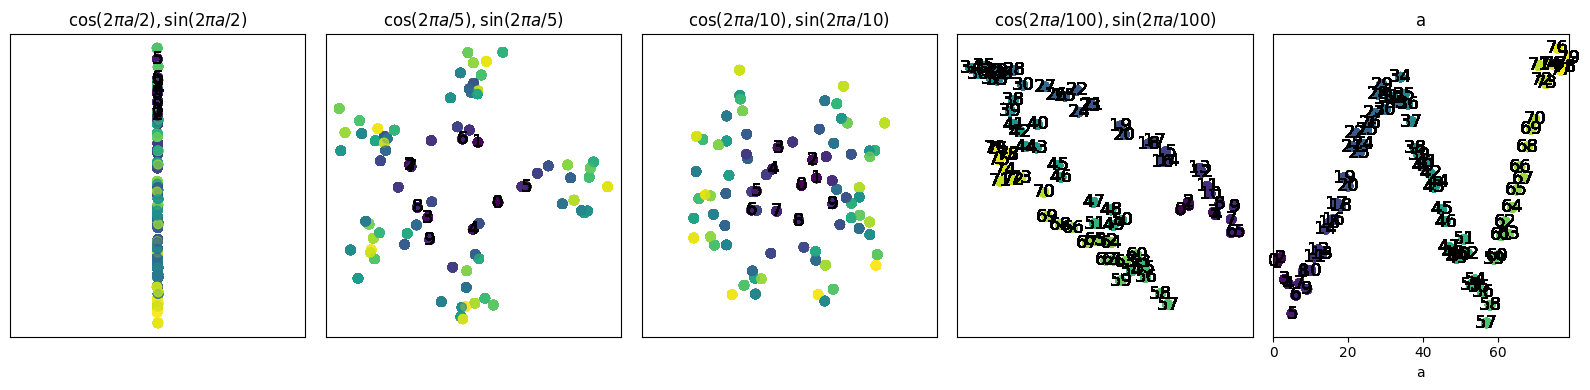

In [41]:
hel_cords = visualize_helical_projection(activations_a, a_values)

Компоненты с периодами 5, 10 и 100 (помним, что в трейн дате нет токенов а больше 80) зафитились нормально. Линейный компонент выглядит странно, но хотя бы по порядку. Компоненты для периода 2 - и синус, и косинус - выглядят оч странно 

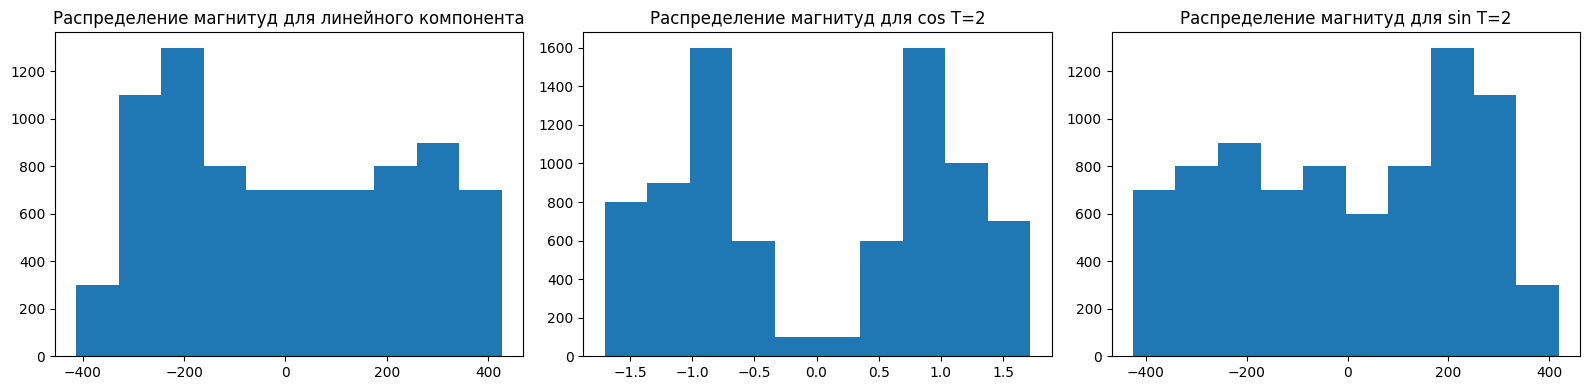

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

axs[0].hist(hel_cords[:, 0])
axs[0].set_title("Распределение магнитуд для линейного компонента")

axs[1].hist(hel_cords[:, 1])
axs[1].set_title("Распределение магнитуд для cos T=2")

axs[2].hist(hel_cords[:, 2])
axs[2].set_title("Распределение магнитуд для sin T=2")

plt.tight_layout()
plt.show()

посмотрим на такие же графики для слоя из середины

activations_pca = (8000, 100)
c_pca shape = (9, 100)
c_full shape = (9, 1600)
pseudo inverse shape = (1600, 9)
activations shape = (8000, 1600)
helical_coords shape: (8000, 9)
period = 2 cos comp shape = (8000,)
period = 5 cos comp shape = (8000,)


/tmp/ipykernel_35/3349284642.py:43: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



period = 10 cos comp shape = (8000,)
period = 100 cos comp shape = (8000,)


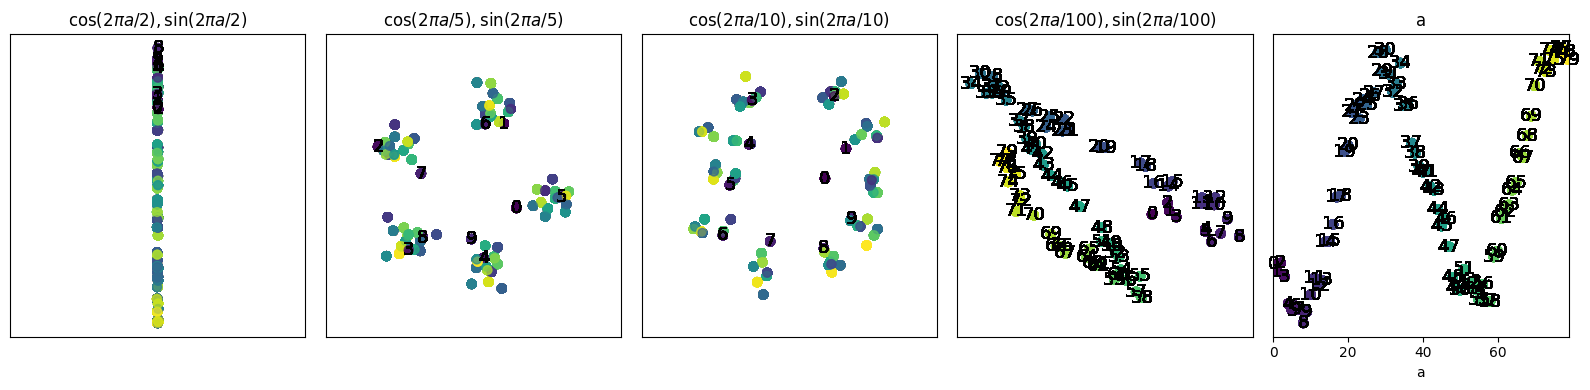

In [47]:
activations_layer_20 = raw_activations[20]
activations_a = []
for prompt_activation in activations_layer_20:
    activations_a.append(prompt_activation[5])
activations_a = np.stack(activations_a, axis=0)
a_values = [p['a'] for p in train_prompts]

hel_cords = visualize_helical_projection(activations_a, a_values)

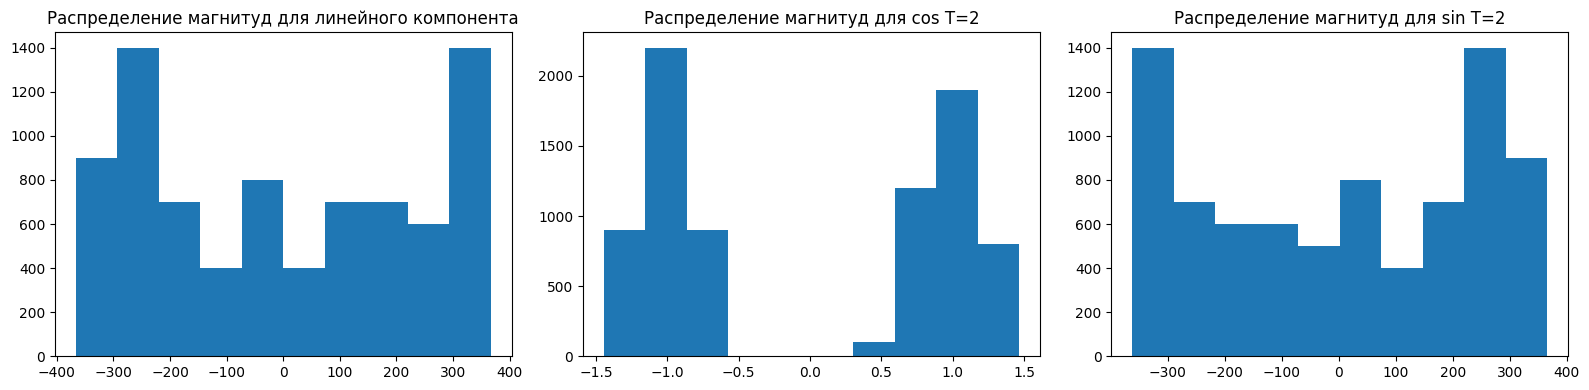

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

axs[0].hist(hel_cords[:, 0])
axs[0].set_title("Распределение магнитуд для линейного компонента")

axs[1].hist(hel_cords[:, 1])
axs[1].set_title("Распределение магнитуд для cos T=2")

axs[2].hist(hel_cords[:, 2])
axs[2].set_title("Распределение магнитуд для sin T=2")

plt.tight_layout()
plt.show()

### activation patching для тестовых промптов

In [73]:
prompt = "Output ONLY a number. 137+138="

input_ids = tokenizer(prompt, return_tensors="pt").to(device)

gen_tokens = model.generate(
    **input_ids,
    tokenizer=tokenizer,
    do_sample=False,
    stop_strings='<|endoftext|>',
    max_new_tokens=1
)
gen_text = tokenizer.batch_decode(gen_tokens)
gen_text

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['Output ONLY a number. 137+138=275']

In [96]:
prompt = "Calculate 137+138="

input_ids = tokenizer_gpt2xl(prompt, return_tensors="pt")

gen_tokens = model_gpt2xl.generate(
    **input_ids,
    tokenizer=tokenizer_gpt2xl,
    do_sample=False,
    stop_strings='<|endoftext|>',
    max_new_tokens=20
)
gen_text = tokenizer_gpt2xl.batch_decode(gen_tokens)
gen_text

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['Calculate 137+138=149\n\n149-150=0\n\n151-152=0\n\n153-154']

In [92]:
prompt = "Output ONLY a number. 137+138="

input_ids = tokenizer_gpt2xl_finetuned(prompt, return_tensors="pt")

gen_tokens = model_gpt2xl_finetuned.generate(
    **input_ids,
    tokenizer=tokenizer_gpt2xl_finetuned,
    do_sample=False,
    stop_strings='<|endoftext|>',
    max_new_tokens=1
)
gen_text = tokenizer_gpt2xl_finetuned.batch_decode(gen_tokens)
gen_text

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['Output ONLY a number. 137+138=275']